In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Data cleaning

Reading in data

In [2]:
data_raw = pd.read_pickle('data.pickle')

Cleaning up the columns names to make them easier to reference

In [4]:
data_raw.columns = data_raw.columns.str.lower()
data_raw.columns = data_raw.columns.str.replace(' ', '_')

In [6]:
data_raw[data_raw.columns[2:]] = data_raw[data_raw.columns[2:]].apply(pd.to_numeric, axis =1, result_type="expand")

The 2015-2016 season was missing the saves per game stat (found during scraping). The documentation gives us the calculation for save_percentage, which can be reversed to calculate saves per game from save percentage and goals against:

In [7]:
data_raw['saves_per_game'] = data_raw.saves_per_game.fillna((data_raw.save_percentage * data_raw.goals_against_average)/
                                      (1-data_raw.save_percentage))

The 2012-2013 season is missing so much data I decided to drop it entirely. It looks like the division was much smaller then and statistics are not as readily available

In [9]:
data_raw = data_raw[data_raw.season != '2012-13']

`scoring margin` is missing in a lot of rows. The way to calculate it involves knowing scoring defense or total minutes played, neither of which is reported. However, we can get the total minutes played from the scoring average and the goals per game * nr of games.\
\
After adding the calculated scoring margin, it looks like only positive scoring margins were reported initially. The mean changes from a positive number to ~0 and the min (which was ~0) is now -5

In [10]:
data_raw['total_goals_scored'] = round(data_raw.goals_per_game * data_raw.games)
data_raw['total_goals_against'] = round(data_raw.goals_against_average * data_raw.games)
data_raw['goals_against_per_game'] = data_raw.total_goals_against / data_raw.games

<ipython-input-10-074cf79c7e24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['total_goals_scored'] = round(data_raw.goals_per_game * data_raw.games)
<ipython-input-10-074cf79c7e24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['total_goals_against'] = round(data_raw.goals_against_average * data_raw.games)
<ipython-input-10-074cf79c7e24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [11]:
data_raw['minutes_played'] = (data_raw.total_goals_scored * 60)/data_raw.scoring_average
data_raw['scoring_defense'] = (data_raw.total_goals_against * 60) / data_raw.minutes_played

<ipython-input-11-8691f3db3cae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['minutes_played'] = (data_raw.total_goals_scored * 60)/data_raw.scoring_average
<ipython-input-11-8691f3db3cae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['scoring_defense'] = (data_raw.total_goals_against * 60) / data_raw.minutes_played


In [12]:
data_raw['scoring_margin'] = data_raw.scoring_margin.fillna(data_raw.scoring_average - data_raw.scoring_defense)

<ipython-input-12-a85e32bd155a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['scoring_margin'] = data_raw.scoring_margin.fillna(data_raw.scoring_average - data_raw.scoring_defense)


At this point I have cleaned up the most egregious missing data. I will drop any rows that still have missing data points, since there are no clear patterns I can fix

In [14]:
is_NaN = data_raw.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data_raw[row_has_NaN]

In [15]:
data_clean = data_raw.dropna()

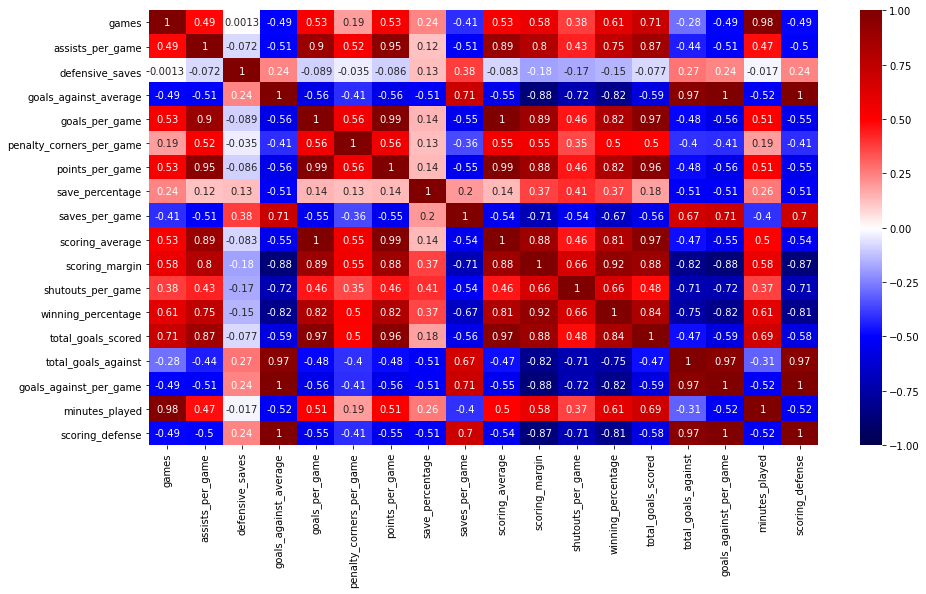

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap(data_clean.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Looking at the correlations and the description of the stats [here](http://fs.ncaa.org/Docs/stats/Stats_Manuals/FH/FH_Stats_Man.pdf), it is clear that some of the 'average' stats are directly related to the "per game" stats. They are just slightly different calculations based on minutes played instead of single games. I am choosing to keep the per game stats here and drop the average stats.\
The exception is saves per game and save percentage, where the save percentage includes goals allowed, so is more an engineered feature than a direct replacement. I am keeping both of those for now

In [17]:
data_clean.drop(columns=['games', 'goals_against_average', 'scoring_average', 'goals_against_average', 'total_goals_scored',
                        'total_goals_against', 'minutes_played', 'scoring_defense', 'points_per_game', 'defensive_saves'],inplace=True)

/Users/stephan/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
data_clean.to_pickle('data_clean.pickle')